### Generacion de señales

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import signal
import pywt
from scipy.stats import entropy
from collections import deque 
from collections import defaultdict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [10]:

#np.random.seed(42) 
def signals_class(n_signals, n_samples, fs, t, f1, f2):
    # Generar señales
    signals = []
    for _ in range(n_signals):
        # Desfase aleatorio entre 0 y 2*pi para cada señal
        phase_1 = np.random.uniform(0, 2 * np.pi)
        phase_2 = np.random.uniform(0, 2 * np.pi)
        
        signal1 = np.sin(2 * np.pi * f1 * t) * phase_1
        signal2 = np.cos(2 * np.pi * f2 * t) * phase_2
        signal3 = np.cos(3 * np.pi * t + phase_2) * 5
        
        # Sumar las dos señales
        signal = signal1 + signal2 + signal3
        signals.append(signal)

    # Convertir la lista de señales a un array de numpy
    signals_array = np.array(signals)

    # Mostrar una señal de ejemplo
    plt.plot(t, signals_array[0])
    plt.title("Señal 1 con desfases aleatorios")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()
    return signals_array

    

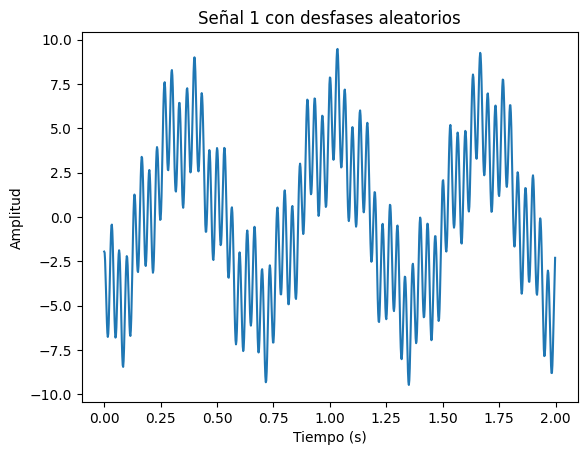

In [11]:
# Definir parámetros clase 1
n_signals = 100
n_samples = 1000
fs = 500  # Frecuencia de muestreo en Hz
t = np.arange(n_samples) / fs  # Vector de tiempo
f1 = 8
f2 = 30

clase_1 = signals_class(n_signals, n_samples, fs, t, f1, f2)


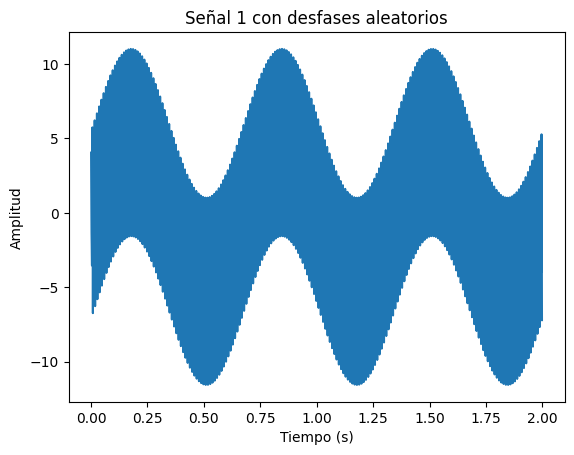

In [12]:
# Definir parámetros clase 2
f1 = 200
f2 = 300

clase_2 = signals_class(n_signals, n_samples, fs, t, f1, f2)

### LDB

In [13]:
class WP_LDB():
    def __init__(self, signals_array, classes_array, wavelet='bior2.8', levels_decomposition=5):
        self.signals_array = signals_array
        self.classes_array = classes_array
        self.wavelet = wavelet
        self.levels_decomposition = levels_decomposition
    
    def WP_energy(self):

        def wp_decomposition(signal):
            wpt = pywt.WaveletPacket(data=signal, wavelet=self.wavelet, mode='periodization',maxlevel=self.levels_decomposition)
            return wpt
        
        def wp_energy_decomposition(wpt):
            energy_per_node = {}
            node_names = [] 
            total_coefficients_energy = 0.0
            
            for level in range(self.levels_decomposition + 1):
                nodes_at_level = wpt.get_level(level)
                for node in nodes_at_level:
                    energy = np.sum(node.data ** 2)
                    total_coefficients_energy += energy
            
            for level in range(self.levels_decomposition + 1):
                nodes_at_level = wpt.get_level(level)
                for node in nodes_at_level:
                    energy = np.sum(node.data ** 2)
                    energy_per_node[node.path] = energy / total_coefficients_energy
                    node_names.append(node.path)           
            return energy_per_node, node_names

        def Energy_nodes(data, nodes_names):
            energy_per_level = defaultdict(list)  
            for trial in data: 
                for node, value in trial.items():  
                    energy_per_level[node].append(value) 
            return dict(energy_per_level) 

        WP_class_1 = []
        WP_class_0 = []
        all_node_names = []
        for signal, cls in zip(self.signals_array,self.classes_array):
            wp = wp_decomposition(signal)
            energy_per_node, node_names = wp_energy_decomposition(wp)
            for name in node_names:
                if name not in all_node_names:
                    all_node_names.append(name)
            if cls == 1:           
                WP_class_1.append(energy_per_node)
            else:
                WP_class_0.append(energy_per_node)

        for trial in WP_class_0 + WP_class_1:
            for node in all_node_names:
                if node not in trial:
                    trial[node] = 0.0
            
        Enode_class0 = {node: [trial[node] for trial in WP_class_0] for node in all_node_names}
        Enode_class1 = {node: [trial[node] for trial in WP_class_1] for node in all_node_names}

        return Enode_class0, Enode_class1, all_node_names
    
    def WP_discrimination(self, Enode_class0, Enode_class1, nodes_names, dis_method = 'KL'):

        def Fisher_Criteria(Class_0, Class_1):
            mu_c0 = np.mean(Class_0)
            mu_c1 = np.mean(Class_1)
            sigma_c0 = np.var(Class_0, ddof=1)  
            sigma_c1 = np.var(Class_1, ddof=1)
    
            denominator = sigma_c0 + sigma_c1
            if denominator == 0:
                return 0.0  
            FD = (mu_c0 - mu_c1)**2 / denominator
            return FD
            # Cuanto mayor sea FD mas separadas están las clases
        
        def kullback_Leibler(Class_0, Class_1, bins=20, epsilon=1e-10):
            min_val = min(np.min(Class_0), np.min(Class_1))
            max_val = max(np.max(Class_0), np.max(Class_1))
            
            hist_c0, _ = np.histogram(Class_0, bins=bins, range=(min_val, max_val), density=True)
            hist_c1, _ = np.histogram(Class_1, bins=bins, range=(min_val, max_val), density=True)
            
            hist_c0 += epsilon
            hist_c1 += epsilon
            
            p = hist_c0 / np.sum(hist_c0)
            q = hist_c1 / np.sum(hist_c1)
            
            kl_divergence = np.sum(p * np.log(p / q))
            return kl_divergence
        
        def diferential_energy(Class_0, Class_1):
            energy_A = np.mean(np.square(Class_0))
            energy_B = np.mean(np.square(Class_1))
            return np.abs(energy_A - energy_B)
        
        def compute_renyi_entropy(coeffs, alpha=2, bins=20, epsilon=1e-10):
            hist, _ = np.histogram(coeffs, bins=bins, density=True)
            hist += epsilon
            hist /= np.sum(hist) 
            if alpha == 1:
                return -np.sum(hist * np.log(hist))  
            else:
                return (1 / (1 - alpha)) * np.log(np.sum(hist ** alpha))
            
        def renyi_diff(Class_0, Class_1, alpha=2, bins=20):
            H0 = compute_renyi_entropy(Class_0, alpha, bins)
            H1 = compute_renyi_entropy(Class_1, alpha, bins)
            return np.abs(H0 - H1)

        
        Discriminant = []
        for node in nodes_names:
            if dis_method == 'KL':
                Discriminant.append(kullback_Leibler(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'FC':
                Discriminant.append(Fisher_Criteria(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'DE':
                Discriminant.append(diferential_energy(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'RY':
                Discriminant.append(renyi_diff(Enode_class0[node],Enode_class1[node]))
        nodes_names[0] = 'root'
        return nodes_names, Discriminant

from collections import deque

class Node:
    def __init__(self, score, name):
        self.score = score  
        self.name = name
        self.base = None    
        self.a = None    
        self.d = None

    @staticmethod
    def build_binary_tree(scores, names):
        if not scores or scores[0] is None:
            return None

        root = Node(scores[0], names[0])
        queue = deque([root])
        index = 1

        while queue and index < len(scores):
            current_node = queue.popleft()

            # Left child
            if index < len(scores) and scores[index] is not None:
                current_node.a = Node(scores[index], names[index])
                queue.append(current_node.a)
            index += 1

            # Right child
            if index < len(scores) and scores[index] is not None:
                current_node.d = Node(scores[index], names[index])
                queue.append(current_node.d)
            index += 1

        return root
    
    def print_tree(root):
        if not root:
            return

        queue = deque([(root, 0)])  
        niveles = {} 

        while queue:
            node, level = queue.popleft()
            
            if level not in niveles:
                niveles[level] = []
            niveles[level].append(f"{node.name}({node.score})")
            
            if node.a:
                queue.append((node.a, level + 1))
            if node.d:
                queue.append((node.d, level + 1))

        for level in sorted(niveles.keys()):
            print("    " * (len(niveles) - level), "  ".join(niveles[level]))

    
    def prune(self, modified_nodes = None):
        if self is None:
            return None
        
        if modified_nodes is None:
            modified_nodes = []  

        if self.a:
            self.a = self.a.prune()
        if self.d:
            self.d = self.d.prune()

        suma_hijos = 0
        if self.a:
            suma_hijos += self.a.score
        if self.d:
            suma_hijos += self.d.score

        if suma_hijos > self.score:
            if self.a and self.d:
                self.score = self.a.score + self.d.score
                modified_nodes.append(self.a.name)
                modified_nodes.append(self.d.name) 
                self.name = f'{self.a.name}-{self.d.name}' 
                self.a = None
                self.d = None
        else:
            if self.a:
                self.a = None
            if self.d:
                self.d = None
        
        self.base = self.name.split('-')
        return self
    
    def discriminant_base(self, discriminant, nodes):
        index = []
        scores = []
        for node in self.base:
            index.append(nodes.index(node))
        for i in index:
            scores.append(discriminant[i])
        combination = list(zip(scores, self.base))
        combination.sort(key=lambda x: x[0], reverse=True)
        scores, nodes = zip(*combination)
        #print(scores)
        #print(nodes)
        return nodes, scores  

In [14]:
class LDB_Decomposition():
    def __init__(self, X, y, mother = 'bior2.8' ,discriminant_method = 'KL', level = 5):
        self.X = X
        self.y = y
        self.mother = mother
        self.discriminant_method = discriminant_method
        self.level = level
        self.basis = None
        self.basis_score = None
        self.nodes_names = None

    def LDB_WP(self): 
        wp = WP_LDB(self.X, self.y, self.mother)
        Ec0, Ec1, nodes = wp.WP_energy()
        self.nodes_names = nodes
        nodes, discriminant = wp.WP_discrimination(Ec0, Ec1, nodes, dis_method = self.discriminant_method)
        tree = Node.build_binary_tree(discriminant, nodes)
        Node.print_tree(tree)
        tree.prune()
        self.basis, self.basis_score = tree.discriminant_base(discriminant, nodes)

    def LDB_fit(self, X):
        
        def wp_decomposition(self, signal):
            wpt = pywt.WaveletPacket(data=signal, wavelet=self.mother, mode='periodization',maxlevel=self.level)
            return wpt

        features = []
        for signal in X:
            coeficients = np.array([])
            s = wp_decomposition(self,signal)
            for node in self.basis:
                coeficients = np.concatenate((coeficients,s[node].data))
            #print((coeficients))
            features.append(coeficients)
        return features
    
    def nodes_maps(self, cmap_name='winter'):
        # Precomputación de valores
        max_score = np.max(self.basis_score) or 1e-10  # Evitar división por cero
        scores_norm = self.basis_score / max_score
        scores_norm = np.linspace(1, 0, len(self.basis_score))
        cmap = plt.get_cmap(cmap_name)
        
        # Mapeo de colores optimizado
        color_dict = {node: cmap(score) 
                    for node, score in zip(self.basis, scores_norm)}
        
        # Configuración inicial del plot
        fig, ax = plt.subplots(figsize=(4, 10))
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Parámetros geométricos
        base_width = 1.0
        level_heights = np.linspace(0, -1, self.level + 1)  # Espaciado uniforme entre niveles
        height = -1 / (self.level + 1)  # Altura proporcional al número de niveles
        
        for level in range(self.level + 1):
            n_nodes = 2 ** level
            node_width = base_width / n_nodes
            
            for node_idx in range(n_nodes):
                x_pos = node_idx * node_width
                y_pos = level_heights[level]  # Sin escalamiento extra

                node_name = self._get_node_name(level, node_idx)
                edge_color = 'black'
                face_color = color_dict.get(node_name, 'white')

                rect = patches.Rectangle(
                    (x_pos, y_pos),
                    node_width,
                    height,  # Usa la nueva altura proporcional
                    edgecolor=edge_color,
                    facecolor=face_color,
                    linewidth=0.5
                )
                ax.add_patch(rect)

         # Añadir título
        ax.set_title("Discriminant nodes map", fontsize=16)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
        cbar.set_label('Discriminant score', fontsize=12)
    
        plt.autoscale()
        plt.tight_layout()
        return fig, ax

    def _get_node_name(self, level, idx):
        """Genera nombres de nodos basado en nivel e índice"""
        if level == 0:
            return 'root'
        return ''.join(['d' if (idx >> i) & 1 else 'a' 
                    for i in reversed(range(level))])
                


nodos [<pywt._wavelet_packets.WaveletPacket object at 0x000001DCDCD7D550>]
nodos [<pywt._wavelet_packets.Node object at 0x000001DCCE4AC5F0>, <pywt._wavelet_packets.Node object at 0x000001DCDCBE96A0>]
nodos [<pywt._wavelet_packets.Node object at 0x000001DCCE3D4260>, <pywt._wavelet_packets.Node object at 0x000001DCDCE9A7E0>, <pywt._wavelet_packets.Node object at 0x000001DCDCF09700>, <pywt._wavelet_packets.Node object at 0x000001DCDCF09A60>]
nodos [<pywt._wavelet_packets.Node object at 0x000001DCDCDE4EF0>, <pywt._wavelet_packets.Node object at 0x000001DCDCDE51F0>, <pywt._wavelet_packets.Node object at 0x000001DCDCDE4EC0>, <pywt._wavelet_packets.Node object at 0x000001DCDCEBB590>, <pywt._wavelet_packets.Node object at 0x000001DCDD50ECF0>, <pywt._wavelet_packets.Node object at 0x000001DCDD051880>, <pywt._wavelet_packets.Node object at 0x000001DCDF628770>, <pywt._wavelet_packets.Node object at 0x000001DCDF628710>]
nodos [<pywt._wavelet_packets.Node object at 0x000001DCDD49CA40>, <pywt._wavel

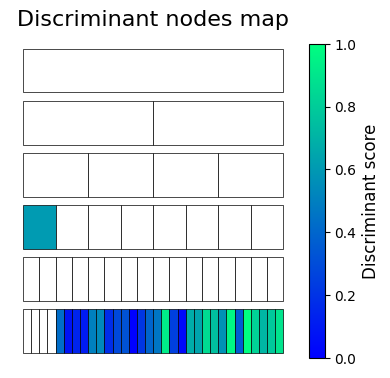

In [15]:
X = np.concatenate((clase_1,clase_2), axis=0)
y = np.concatenate((np.ones(n_signals),np.zeros(n_signals)), axis=0)

wp = LDB_Decomposition(X, y, discriminant_method='KL') #discriminant_method='KL','FC','DE','RY'
wp.LDB_WP()
print(wp.basis)
print(wp.basis_score)
wp.nodes_maps()
x = wp.LDB_fit(X)
X = np.array(x)

### clasificador

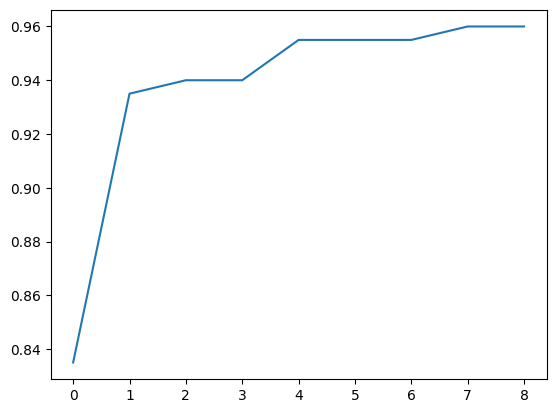

In [16]:
from sklearn.model_selection import cross_val_score

X_data = X  
lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

acc = []
for coeficients in range(1,10):
    X = X_data[:, :coeficients]
    run_acc = []
    for run in range(4):
        scores = cross_val_score(lda, X, y, cv=5, scoring='accuracy')
        run_acc.append(np.mean(scores))
    acc.append(np.mean(run_acc))

plt.figure()
plt.plot(acc)
plt.show()
